In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
OUT_DIR = Path("~/simulation-outputs/ld-benchmarks/output-1586895/").expanduser()
PARAMS = Path("~/simulation-outputs/ld-benchmarks/params.csv").expanduser()

In [3]:
def melt_variable(df, var_name, sep, dtype):
    return (
        df[var_name]
        .str.split(sep, expand=True)
        .astype(dtype)
        .reset_index()
        .melt(id_vars="rep", value_name=var_name)
        .drop("variable", axis=1)
        .reset_index(drop=True)
    )


def gather_mode_data(df, variable, fixed_variable):
    add_columns = melt_variable(df, variable, "/", float).join(
        melt_variable(df, "seed", "-", int), rsuffix="seed"
    )
    assert (add_columns["rep"] == add_columns["repseed"]).all(), "bad join"
    add_columns.drop(["repseed"], axis=1, inplace=True)
    add_columns.set_index("rep", inplace=True)
    df = df.drop(["seed", variable], axis=1).join(add_columns)
    df[fixed_variable] = df[fixed_variable].astype(float)
    return df


def load_params(filename):
    params_raw = pd.read_csv(
        filename,
        names=[
            "mode",
            "rep",
            "ne",
            "recomb",
            "mu",
            "samples",
            "sequence_length",
            "seed",
        ],
        index_col="rep",
    )
    site_params = params_raw[params_raw["mode"] == "site"]
    branch_params = params_raw[params_raw["mode"] == "branch"]
    params = pd.concat(
        [
            gather_mode_data(site_params, "mu", "recomb"),
            gather_mode_data(branch_params, "recomb", "mu"),
        ]
    ).reset_index()
    # run some checks. Ensure seeds correspond to rep and everything is properly ordered
    seed_check = params_raw.seed.str.split("-").apply(lambda s: list(map(int, s)))
    mu_check = params_raw.mu.str.split("/").apply(lambda s: list(map(float, s)))
    recomb_check = params_raw.recomb.str.split("/").apply(lambda s: list(map(float, s)))
    for rep, df in params.groupby("rep"):
        assert seed_check[rep] == list(df.seed)
        if len(mu_check[rep]) == 1:
            assert set(mu_check[rep]) == set(df.mu)
        else:
            assert mu_check[rep] == list(df.mu)
        if len(recomb_check[rep]) == 1:
            assert set(recomb_check[rep]) == set(df.recomb)
        else:
            assert recomb_check[rep] == list(df.recomb)
    assert params_raw.drop(["seed", "mu", "recomb"], axis=1).equals(
        params.drop(["seed", "mu", "recomb"], axis=1)
        .drop_duplicates(ignore_index=True)
        .set_index("rep")
    )
    params["subrep"] = pd.Series(
        np.hstack([np.arange(c) for c in params.rep.value_counts(sort=False)])
    )
    assert (params.subrep.isnull() == False).all()

    # NB: small correction because I messed up my parameter generation script
    params["rep_orig"] = params["rep"]
    params.loc[params["mode"] == "branch", "rep"] -= 30000 - 600
    return params

In [4]:
params = load_params(PARAMS)
# result_dirs = OUT_DIR / "result" / (params.rep.drop_duplicates().astype(str) + ".npz")
# NB: small correction because I messed up my parameter generation script
result_dirs = (
    OUT_DIR / "result" / (params.rep_orig.drop_duplicates().astype(str) + ".npz")
)

In [5]:
params

,rep,mode,ne,recomb,samples,sequence_length,mu,seed,subrep,rep_orig
0,0,site,10000,1.000000e-05,500,5000,1.000000e-07,74293844,0,0
1,0,site,10000,1.000000e-05,500,5000,1.000000e-07,726266599,1,0
2,0,site,10000,1.000000e-05,500,5000,3.457931e-05,1919689769,2,0
3,0,site,10000,1.000000e-05,500,5000,3.457931e-05,794519498,3,0
4,0,site,10000,1.000000e-05,500,5000,6.905862e-05,1140140983,4,0
...,...,...,...,...,...,...,...,...,...,...
59995,1199,branch,10000,9.317241e-07,250,1000,0.000000e+00,1114897268,45,30599
59996,1199,branch,10000,9.658621e-07,250,1000,0.000000e+00,1350749963,46,30599
59997,1199,branch,10000,9.658621e-07,250,1000,0.000000e+00,993803248,47,30599
59998,1199,branch,10000,1.000000e-06,250,1000,0.000000e+00,1304311114,48,30599


In [6]:
def load_results(result_dirs):
    timing_results = []
    tree_stats = []
    cpu_info = []

    for f in result_dirs:
        r = np.load(f)
        cpu_info.append(json.loads(r["cpu_info"].flat[0].decode("utf-8")))
        tree_stats.append(r["tree_stats"])
        timing_results.append(r["timing_result"].flatten())
    timing_results = np.vstack(timing_results)
    tree_stats = pd.DataFrame(
        np.vstack(tree_stats),
        columns=["num_edges", "num_trees", "num_mutations", "num_sites"],
    )
    cpu_info = pd.DataFrame.from_dict(
        {
            i: {d["field"]: d["data"] for d in info["lscpu"]}
            for i, info in enumerate(cpu_info)
        },
        orient="index",
    ).rename(columns=lambda s: s.strip(":"))
    return timing_results, tree_stats, cpu_info

In [7]:
timing_results, tree_stats, cpu_info = load_results(result_dirs)
assert np.prod(timing_results.shape) == len(params)
assert len(tree_stats) == len(params)
assert len(cpu_info) == len(params.rep.drop_duplicates())

In [8]:
tree_stats

,num_edges,num_trees,num_mutations,num_sites
0,48063,4637,148,147
1,46470,4614,125,124
2,48916,4673,52465,5000
3,48341,4668,50086,5000
4,48153,4637,102001,5000
...,...,...,...,...
59995,1956,234,0,0
59996,1776,194,0,0
59997,1878,213,0,0
59998,1945,228,0,0


In [9]:
timing_results

array([[3.05636488e-02, 2.00486146e-02, 8.27153361e+01, ...,
        1.23881135e+02, 1.32633309e+02, 1.37993599e+02],
       [3.87578607e-02, 3.35250497e-02, 9.58986779e+01, ...,
        8.25319433e+01, 8.44642335e+01, 8.33466046e+01],
       [3.40184122e-02, 1.17621794e+02, 1.25122526e+02, ...,
        1.35195741e+02, 1.35347916e+02, 1.32868808e+02],
       ...,
       [5.07013640e-01, 1.39513768e-01, 7.34775590e-01, ...,
        2.14194667e+02, 1.95209286e+02, 2.31445673e+02],
       [1.85765345e-01, 2.75810795e-01, 1.73260375e+00, ...,
        1.44208703e+02, 1.37265811e+02, 1.41040989e+02],
       [4.41047454e-01, 1.41348356e+00, 2.63327617e+00, ...,
        2.07102026e+02, 2.72043387e+02, 1.85954069e+02]])

In [10]:
cpu_info.loc[
    :,
    ~cpu_info.columns.str.startswith("Vuln")
    & ~cpu_info.columns.str.startswith("NUMA")
    & ~cpu_info.columns.isin(
        {
            "CPU op-mode(s)",
            "Byte Order",
            "Address sizes",
            "On-line CPU(s) list",
            "Core(s) per socket",
            "Socket(s)",
        }
    ),
]

,Architecture,CPU(s),Thread(s) per core,Vendor ID,CPU family,Model,Model name,Stepping,CPU MHz,CPU max MHz,CPU min MHz,BogoMIPS,Virtualization,L1d cache,L1i cache,L2 cache,L3 cache,Flags
0,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,4999.99,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
1,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.780,3300.0000,1200.0000,5000.14,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
2,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,5000.08,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
3,x86_64,40,2,GenuineIntel,6,62,Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz,4,2899.932,3300.0000,1200.0000,5000.25,VT-x,640 KiB,640 KiB,5 MiB,50 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
4,x86_64,128,2,AuthenticAMD,23,49,AMD EPYC 7452 32-Core Processor,0,2903.004,NaN,NaN,4690.78,AMD-V,2 MiB,2 MiB,32 MiB,256 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,x86_64,256,2,AuthenticAMD,25,1,AMD EPYC 7763 64-Core Processor,1,3243.809,NaN,NaN,4890.70,AMD-V,4 MiB,4 MiB,64 MiB,512 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
1196,x86_64,256,2,AuthenticAMD,25,1,AMD EPYC 7763 64-Core Processor,1,3233.197,NaN,NaN,4890.72,NaN,4 MiB,4 MiB,64 MiB,512 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
1197,x86_64,128,2,AuthenticAMD,23,49,AMD EPYC 7452 32-Core Processor,0,2974.764,NaN,NaN,4691.32,AMD-V,2 MiB,2 MiB,32 MiB,256 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...
1198,x86_64,256,2,AuthenticAMD,25,1,AMD EPYC 7763 64-Core Processor,1,2445.350,NaN,NaN,4890.70,AMD-V,4 MiB,4 MiB,64 MiB,512 MiB,fpu vme de pse tsc msr pae mce cx8 apic sep mt...


In [11]:
cpu_info["Flags"].str.contains("sse2").all()

True

In [12]:
cpu_info["Flags"].str.contains("sse3").all()

True

In [13]:
cpu_info["Flags"].str.contains("sse4").all()

True

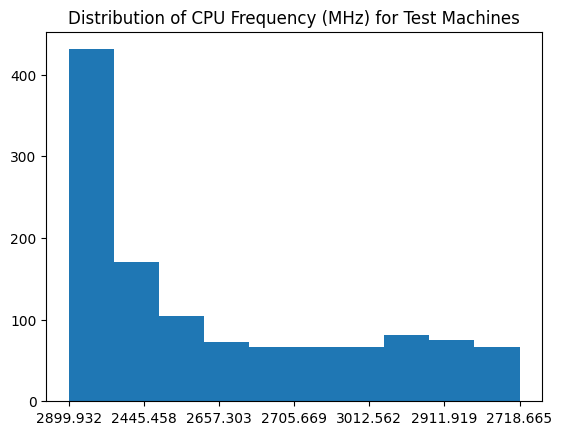

In [14]:
plt.hist(cpu_info["CPU MHz"])
[
    (label.set_visible(False), tick.set_visible(False))
    for i, (label, tick) in enumerate(
        zip(plt.gca().xaxis.get_ticklabels(), plt.gca().xaxis.get_major_ticks())
    )
    if i % 110
]
plt.title("Distribution of CPU Frequency (MHz) for Test Machines");

In [15]:
site = params["mode"] == "site"
branch = params["mode"] == "branch"
for mu, df in params[site].groupby("mu"):
    tree_stats.loc[df.index, 'timing_result'] = timing_results[df.rep, df.subrep]
for recomb, df in params[branch].groupby("recomb"):
    tree_stats.loc[df.index, 'timing_result'] = timing_results[df.rep, df.subrep]

In [16]:
tree_stats

,num_edges,num_trees,num_mutations,num_sites,timing_result
0,48063,4637,148,147,0.030564
1,46470,4614,125,124,0.020049
2,48916,4673,52465,5000,82.715336
3,48341,4668,50086,5000,82.130661
4,48153,4637,102001,5000,88.479659
...,...,...,...,...,...
59995,1956,234,0,0,198.407282
59996,1776,194,0,0,134.770106
59997,1878,213,0,0,207.102026
59998,1945,228,0,0,272.043387


<Axes: >

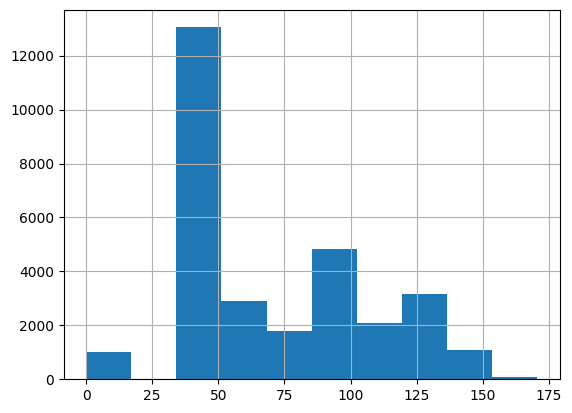

In [17]:
tree_stats[site].timing_result.hist()

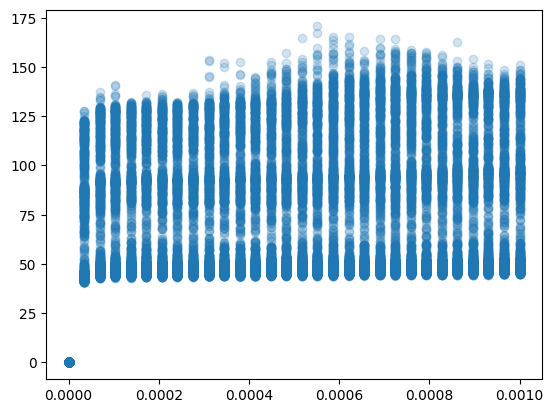

In [18]:
plt.scatter(params[site].mu, tree_stats[site].timing_result, alpha=.2)

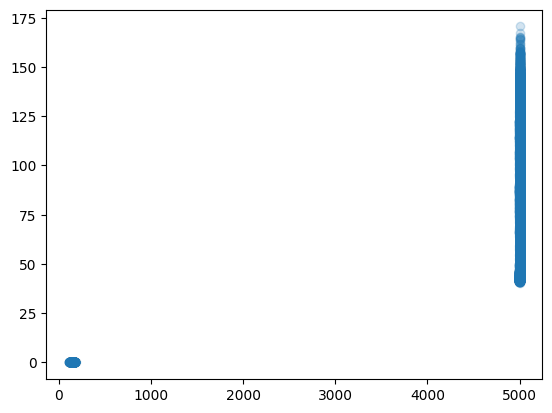

In [19]:
plt.scatter(tree_stats[site].num_sites, tree_stats[site].timing_result, alpha=.2)

Text(0, 0.5, 'Num Sites')

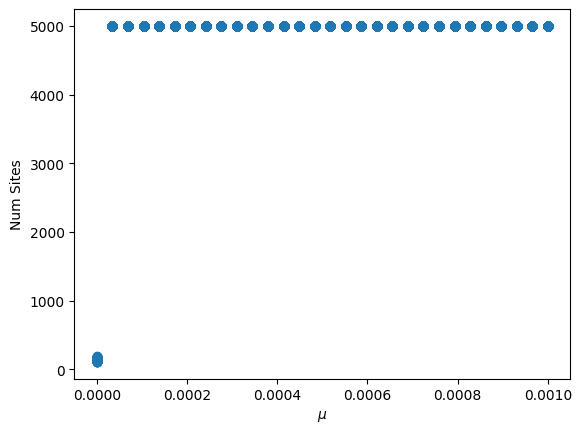

In [20]:
plt.scatter(params[site].mu, tree_stats[site].num_sites)
plt.xlabel(r'$\mu$')
plt.ylabel('Num Sites')

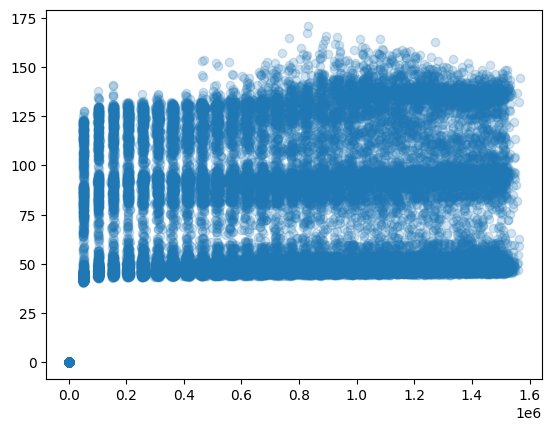

In [21]:
plt.scatter(tree_stats[site].num_mutations, tree_stats[site].timing_result, alpha=.2)

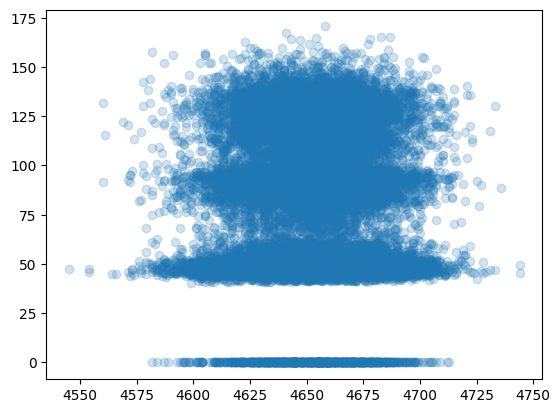

In [22]:
plt.scatter(tree_stats[site].num_trees, tree_stats[site].timing_result, alpha=.2)

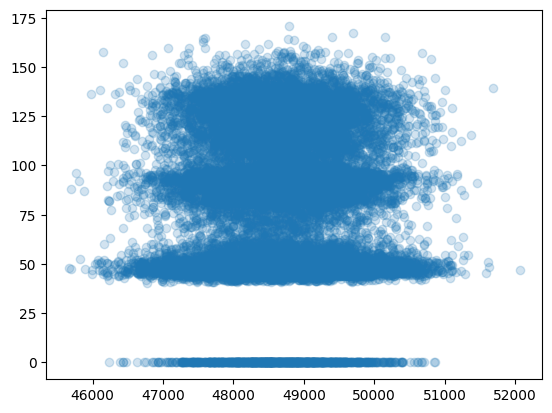

In [23]:
plt.scatter(tree_stats[site].num_edges, tree_stats[site].timing_result, alpha=.2)

In [24]:
cpu_mhz = params[['rep', 'subrep']].join(cpu_info['CPU MHz'].astype(float).to_frame().assign(bin=lambda df: pd.cut(df['CPU MHz'], 10)), on='rep')

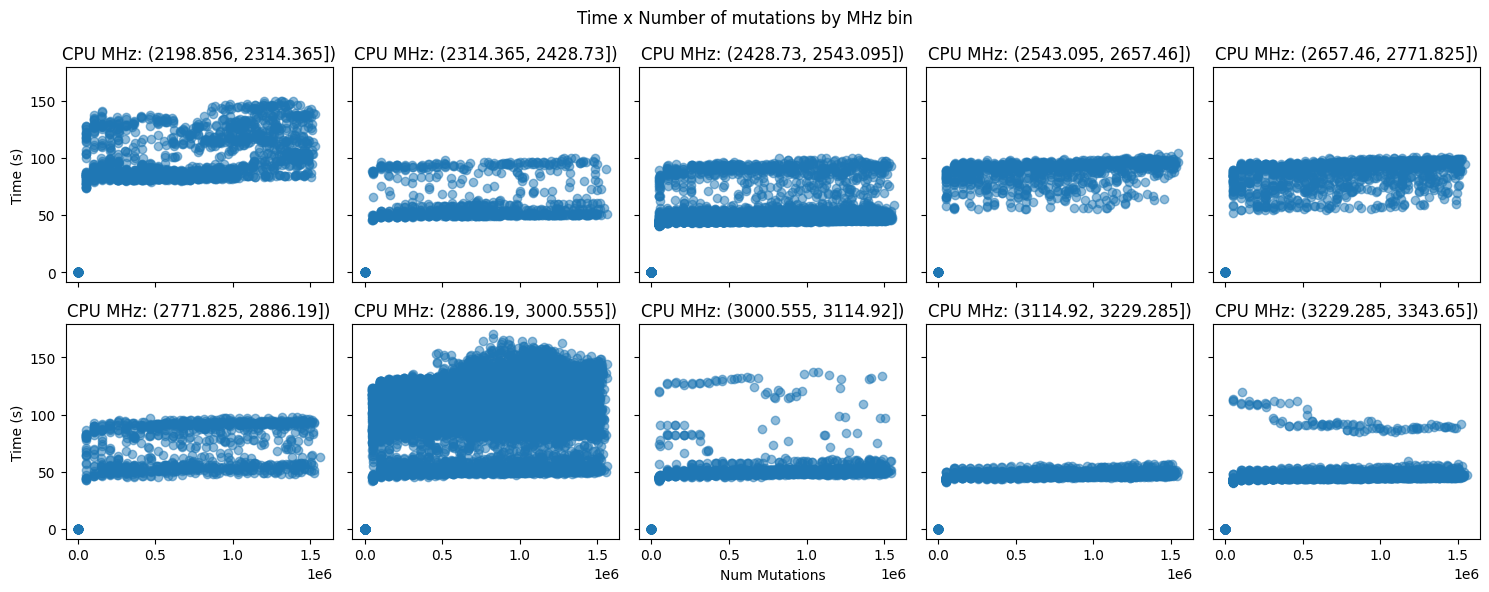

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()
for i, (bin, df) in enumerate(tree_stats.join(cpu_mhz)[site].groupby('bin', observed=True)):
    axes[i].scatter(df.num_mutations, df.timing_result, alpha=.5)
    axes[i].set_title(f'CPU MHz: {bin})')
axes[0].set_ylabel('Time (s)')
axes[5].set_ylabel('Time (s)')
axes[7].set_xlabel('Num Mutations')
plt.suptitle('Time x Number of mutations by MHz bin')
fig.tight_layout()

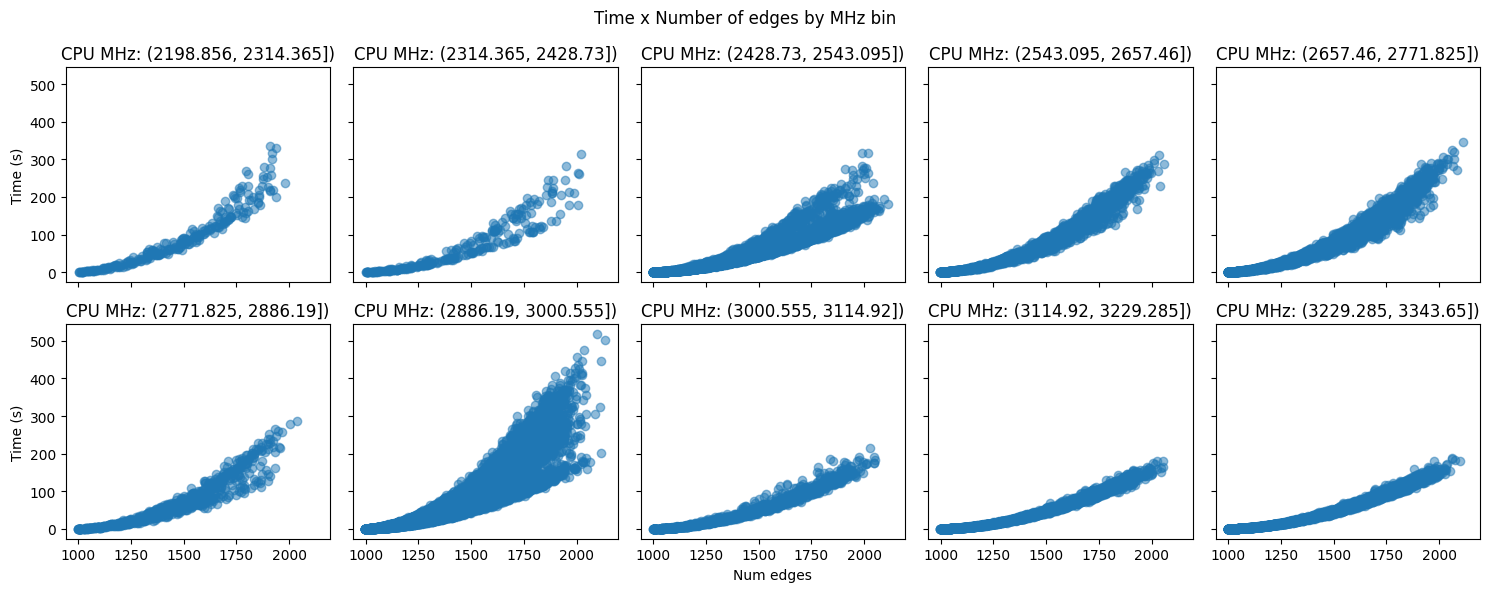

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True, sharex=True)
axes = axes.flatten()
for i, (bin, df) in enumerate(tree_stats.join(cpu_mhz)[branch].groupby('bin', observed=True)):
    axes[i].scatter(df.num_edges, df.timing_result, alpha=.5)
    axes[i].set_title(f'CPU MHz: {bin})')
axes[0].set_ylabel('Time (s)')
axes[5].set_ylabel('Time (s)')
axes[7].set_xlabel('Num edges')
plt.suptitle('Time x Number of edges by MHz bin')
fig.tight_layout()

nlogn??